In [37]:
# Importing libraries required for the assignments
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import pickle
import pprint

import sqlite3
import pandas as pd
import numpy as np
import nltk
import prettytable

import re
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

from sklearn.model_selection import GridSearchCV

#from sklearn.neighbors import KNeighborsClassifier
#from sklearn import cross_validation
#from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,f1_score,make_scorer
#from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
#from sklearn.naive_bayes import MultinomialNB,BernoulliNB,GaussianNB
from sklearn.linear_model import LogisticRegression
#from sklearn.decomposition import TruncatedSVD

In [8]:
pkl_file = open('data1.pkl', 'rb')
filtered_data = pickle.load(pkl_file)
#pprint.pprint(filtered_data)
pkl_file.close()

In [9]:
# Checking columns present in data

filtered_data.columns

Index(['ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'Sentiment',
       'CleanedText'],
      dtype='object')

In [10]:
# Time base sorting

filtered_data.sort_values('Time',inplace=True)

In [11]:
# Filtering only 100K data points for this assignments

filtered_100k=filtered_data.iloc[:100000,:]

In [12]:
filtered_100k.Time.head(20)

61682     948672000
1130      961718400
1129      962236800
26503    1067040000
26502    1067040000
54376    1067472000
35508    1067558400
35655    1067644800
35654    1067904000
10388    1067990400
82577    1068076800
26501    1068076800
81533    1068422400
55130    1068940800
98503    1069027200
75316    1069113600
36417    1069459200
44110    1070668800
22710    1071100800
74752    1071705600
Name: Time, dtype: int64

In [13]:
filtered_100k.reset_index(inplace=True)

In [14]:
label=filtered_100k.Sentiment

In [15]:
# Dropping target column
filtered_100k.drop('Sentiment',axis=1,inplace=True)

In [16]:
# Creating new label from reviews

filtered_100k['Tex_len']=filtered_100k.CleanedText.apply(lambda x:len(x.split(" ")))

In [17]:
filtered_100k.Tex_len.head()

0    28
1    17
2    36
3    10
4    15
Name: Tex_len, dtype: int64

In [18]:
filtered_100k.drop('index',axis=1,inplace=True)

In [19]:
filtered_100k.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,CleanedText,Tex_len
0,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,948672000,A sure death for flies,I bought a few of these after my apartment was...,bought apart infest fruit fli hour trap mani f...,28
1,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,961718400,Great Product,This was a really good idea and the final prod...,realli good idea final product outstand use de...,17
2,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,receiv shipment could hard wait tri product lo...,36
3,B00008RCMI,A284C7M23F0APC,A. Mendoza,0,0,1067040000,Best sugarless gum ever!,I love this stuff. It is sugar-free so it does...,love stuff rot gum tast good go buy gum get,10
4,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,1067040000,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe...",noth product bother link top page buy use chew...,15


### Train Test Split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(filtered_100k, label, test_size=0.3, random_state=50)


In [21]:

print(X_train.shape,len(y_train))
print(X_test.shape,len(y_test))

(70000, 10) 70000
(30000, 10) 30000


### Bag Of Words

In [22]:
# Creating vectorizer

count_vector=CountVectorizer(ngram_range=(1,2),dtype='float')
vocab=count_vector.fit(X_train.CleanedText)

bow_train=count_vector.transform(X_train.CleanedText)
bow_test=count_vector.transform(X_test.CleanedText)

In [23]:
#Data Scaling-Normilizer has given better result than Std scaler

scaler = Normalizer()
scaler.fit(bow_train)
bow_train=scaler.transform(bow_train)
bow_test=scaler.transform(bow_test)

In [20]:
print(bow_train.get_shape())
print(bow_test.get_shape())

(70000, 936298)
(30000, 936298)


## Applying Logistic Regression on Bag of word technique

In [21]:
# Creating summary table to store summary of models
summary_table = prettytable.PrettyTable(["Method","Model","Optimam C", "F-1 Score"])
noise=.001
# defining fait method and validation methods 
def fit_and_val_model(X_train,y_train,X_test,y_test,method,table=summary_table):

    #creating weighted f-1 scorer
    scorer=make_scorer(f1_score,average='weighted')
    
    #model fitting
    tuned_parameters = {'C': [10**-4, 10**-2,10**-1, 10**0, 10**1,10**2, 10**4]}
    model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = scorer, cv=5)
    model.fit(X_train, y_train)


    print(model.best_estimator_)
    print("\nThe model F-1 score is",model.score(X_test, y_test)*100)

    pred = model.predict(X_test)
    f1=f1_score(y_pred=pred,y_true=y_test,pos_label='Positive')
    score=f1*100
    
    print ("\n\nF-1 Scores on test data on optimal parameters is  {:.4f} %\n\n".format(f1*100))
    #Add row to the summary table
    table.add_row([method,'Logistic_Reg',model.best_estimator_.C,score])

    # evaluate accuracy

    cnf_mtrx=confusion_matrix(y_true=y_test, y_pred=pred, labels=None, sample_weight=None)
    print(cnf_mtrx)
    # Heatmap to display
    sns.heatmap(cnf_mtrx,annot=True,cmap='Blues', fmt='g')
    plt.show()
    print (classification_report(y_test, pred))
    
    return model
  

    

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

The model F-1 score is 92.04224426562614


F-1 Scores on test data on optimal parameters is  95.5266 %


[[ 3224  1580]
 [  713 24483]]


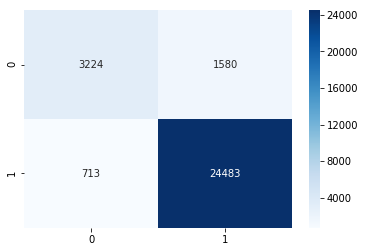

             precision    recall  f1-score   support

   Negative       0.82      0.67      0.74      4804
   Positive       0.94      0.97      0.96     25196

avg / total       0.92      0.92      0.92     30000



In [22]:
#Fitting Model for Bag of word
model_bow=fit_and_val_model(bow_train,y_train,bow_test,y_test,"BOW")

In [26]:


#Function to plot Misclassification error against C
def plot_error_vs_c_r(gsv):
    x1=[]
    y1=[]
    for a in gsv.grid_scores_:
        
            y1.append(1-a[1])
            x1.append(a[0]['C'])

    ind1 = np.argsort(x1)
    x1=np.array(x1)
    y1=np.array(y1)
    plt.xlim(-10,1010)
    plt.ylim(0,0.2)
    plt.xlabel("C",fontsize=15)
    plt.ylabel("Misclassification Error")
    plt.title('Misclassification Error v/s C')
    plt.plot(x1[ind1],y1[ind1],'b')
    plt.legend()
    plt.show()

No handles with labels found to put in legend.


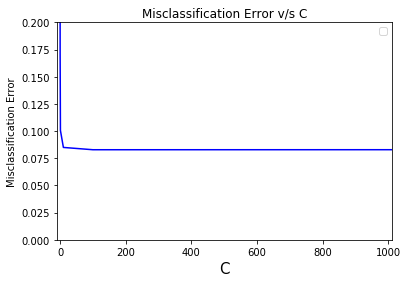

In [27]:
plot_error_vs_c_r(model_bow)

## positive and Negative important features

In [67]:
w = count_vector.get_feature_names()
coef = model_bow.best_estimator_.coef_.tolist()[0]
coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
print('')
print('-Top 20 positive-')
print(coeff_df.head(20).to_string(index=False))
print('')
print('-Top 20 negative-')        
print(coeff_df.tail(20).to_string(index=False))


-Top 20 positive-
Coefficient              Word
  18.080205    high recommend
  15.494530            delici
  15.145266              amaz
  15.093377           perfect
  14.007243             excel
  13.576708              hook
  12.814695             worri
  12.389460              best
  12.194448           skeptic
  11.991574  pleasant surpris
  11.951586             yummi
  11.568554              beat
  11.337003              nice
  11.302593       even better
  11.293159        well worth
  11.220374             great
  11.152751          drawback
  11.148935             uniqu
  10.947321         complaint
  10.802550         five star

-Top 20 negative-
Coefficient        Word
 -13.206646        weak
 -13.535546     unpleas
 -13.957391      return
 -14.225451   never buy
 -14.406827    unfortun
 -14.564792       threw
 -14.690462       shame
 -14.712978      cancel
 -14.798211       trash
 -14.845801     undrink
 -14.887052   want like
 -15.334178       bland
 -15.750716     disg

## Pertubation Test

In [24]:
noise=.001
def fit_and_val(X_train,y_train,X_test,y_test,method):

    scorer=make_scorer(f1_score,average='weighted')
    tuned_parameters = {'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}
    model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = scorer, cv=5)
    model.fit(X_train, y_train)


    print(model.best_estimator_)
    print(model.score(X_test, y_test))
    w=model.best_estimator_.coef_
#    print ("\nmodel performance is {:.4f}  %".format(scores*100))
    X_train.data=(X_train.data+noise)
    model.fit(X_train,y_train)
    w_noise=model.best_estimator_.coef_

    
    return w,w_noise

In [25]:
wieght_vec,wieght_vec_noise=fit_and_val(bow_train,y_train,bow_test,y_test,"BOW")

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.9204224426562614


In [32]:
diff=(abs((wieght_vec-wieght_vec_noise)/(wieght_vec))*100)

In [33]:
print(wieght_vec)

[[ 7.03119146e-04 -9.97335848e-01 -9.97335848e-01 ...  1.27624704e-02
  -3.57295615e-01 -3.57295615e-01]]


In [34]:
print(wieght_vec_noise)

[[ 5.26089189e-04 -9.90273284e-01 -9.90273284e-01 ...  1.14379425e-02
  -3.53569524e-01 -3.53569524e-01]]


In [35]:
print(diff[np.where(diff > 30)].size)

84223


84223 features have weight changes greater than 30%. Hence the features are multicollinear

In [46]:
#Percentile check using elbow method


for i in [0,10,20,30,40,50,60,70,80,90,99,100]:
    print (i,"\t",np.percentile(diff,i))

0 	 1.4695513016860096e-06
10 	 0.2189736010718234
20 	 0.43263692986461355
30 	 0.679063754344147
40 	 1.0250103302539102
50 	 1.6174555993307318
60 	 2.786294695032271
70 	 5.469606667249029
80 	 12.582727301552755
90 	 27.61731048417308
99 	 68.88447121865063
100 	 91574.81955658789


### Since value changes dreastically between 99 percentile and 100th percentile , so checking between 99 to 100

In [47]:
for i in [99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100]:
    print (i,"\t",np.percentile(diff,i))

99.1 	 69.97436319491256
99.2 	 71.10099062682309
99.3 	 72.44470278732685
99.4 	 73.51357381233778
99.5 	 74.65195359424874
99.6 	 75.99353850273316
99.7 	 77.25181503008362
99.8 	 78.4673873990905
99.9 	 83.40415660896264
100 	 91574.81955658789


In [57]:
#Associating word with diff wiegt vector
w = count_vector.get_feature_names()
coef = diff[0]
diff_df = pd.DataFrame({'Word' : w, 'Difference' : coef})

### Printing words which has difference greater than 83.4 and there is 937 such words/feature

In [64]:
print(diff_df.Word[diff_df.Difference > 83.4])

1300         absolut weird
3201            acid decaf
3316          acid ingredi
4631            actual bar
4651           actual best
4703          actual carri
5040          actual jerki
5069          actual lemon
5843             ad distil
6324               ad shot
7066              add herb
7815          addict candi
8495             addit get
8595            addit make
9452          admit defeat
9700               adolesc
10323         advanc stage
10651         advertis get
12532      aftertast found
12789     aftertast though
13108           agav syrup
15233          air obvious
15348              airedal
18812         almost equal
19284         almost sugar
19387         almost worth
19635         alon product
21238            also bite
24284        altogeth much
24341         altoid great
                ...       
909111          well start
909222        well thought
909368          well weird
909394         well within
910665              whatev
912480        whim groceri
9

## Sparsity Check

In [57]:
nbrs_list=[10**4,10**3, 10**2, 10,10**0, 10**-1]
for C in nbrs_list:
    clf = LogisticRegression(C= C, penalty= 'l1')
    clf.fit(bow_train,y_train)
    y_pred = clf.predict(bow_test)
    print("\nFor C={:.4f}".format(C))
    print("F1-Score on test set: {:0.4f}%".format(f1_score(y_test, y_pred,pos_label='Positive')*100))
    print("Non Zero weights:",np.count_nonzero(clf.coef_))


For C=10000.0000
F1-Score on test set: 95.0864%
Non Zero weights: 37888

For C=1000.0000
F1-Score on test set: 94.7948%
Non Zero weights: 18192

For C=100.0000
F1-Score on test set: 94.8506%
Non Zero weights: 14458

For C=10.0000
F1-Score on test set: 95.1257%
Non Zero weights: 9588

For C=1.0000
F1-Score on test set: 95.1877%
Non Zero weights: 1066

For C=0.1000
F1-Score on test set: 93.5323%
Non Zero weights: 169


### Here sparsity increases from 37888 non-zero weights For C=10000 to only 169 non-zero weightsFor C=0.1 when we use L1 Regularization





### TF-IDF intialization and dimension creation

In [28]:
#craeting TF-IDF vectorizer

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
filtered_tf_idf = tf_idf_vect.fit(X_train.CleanedText)
print("the type of count vectorizer ",type(filtered_tf_idf))
#print("the shape of out TF-IDF vectorizer ",filtered_tf_idf.get_shape())

the type of count vectorizer  <class 'sklearn.feature_extraction.text.TfidfVectorizer'>


In [29]:

tf_idf_train=tf_idf_vect.transform(X_train.CleanedText)
tf_idf_test=tf_idf_vect.transform(X_test.CleanedText)

In [30]:
#feature scaling

scaler = Normalizer()
scaler.fit(tf_idf_train)
tf_idf_train=scaler.transform(tf_idf_train)
tf_idf_test=scaler.transform(tf_idf_test)

In [25]:
print(tf_idf_train.get_shape())
print(tf_idf_test.get_shape())

(70000, 936298)
(30000, 936298)


## Applying logistic Regression on TF-IDF

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

The model F-1 score is 92.20937849051664


F-1 Scores on test data on optimal parameters is  95.6255 %


[[ 3241  1563]
 [  680 24516]]


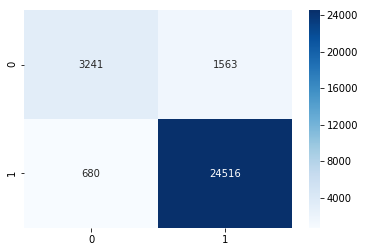

             precision    recall  f1-score   support

   Negative       0.83      0.67      0.74      4804
   Positive       0.94      0.97      0.96     25196

avg / total       0.92      0.93      0.92     30000



In [31]:
#Fitting model against TF-IDF

Model=fit_and_val_model(tf_idf_train,y_train,tf_idf_test,y_test,"TF-IDF")

No handles with labels found to put in legend.


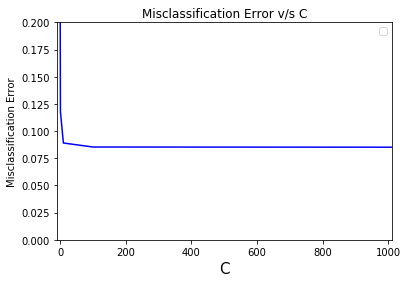

In [32]:
plot_error_vs_c_r(Model)

## Positive and Negative important Feature

In [75]:
w = tf_idf_vect.get_feature_names()
coef = Model.best_estimator_.coef_.tolist()[0]
coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
print('')
print('-Top 20 positive-')
print(coeff_df.head(20).to_string(index=False))
print('')
print('-Top 20 negative-')        
print(coeff_df.tail(20).to_string(index=False))



-Top 20 positive-
Coefficient            Word
  53.268579           great
  46.017515            best
  44.731027          delici
  43.958488            love
  43.533615         perfect
  36.770204           excel
  35.382622            nice
  35.075769  high recommend
  33.296421            amaz
  28.842241            good
  28.389148          wonder
  26.735957         favorit
  26.559487         without
  25.917003           thank
  24.634959           yummi
  24.273313          smooth
  24.203884           worri
  23.827254            hook
  23.821736            easi
  22.859229          awesom

-Top 20 negative-
Coefficient        Word
 -25.994713       shame
 -26.505790      cancel
 -26.827463   never buy
 -27.093618       trash
 -27.292348       sorri
 -27.433316        wast
 -28.324677        weak
 -28.547180       stale
 -28.644562   tasteless
 -30.108636    two star
 -30.139456     disgust
 -30.432148       threw
 -31.611178       bland
 -32.568419    unfortun
 -34.392851   

## Wieghted Word2Vec Model

In [33]:
#Creating sentence vector

list_of_sent=[]
for sent in filtered_100k.CleanedText:
    list_of_sent.append(sent.split())
#Word2vec model
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100000
50


In [34]:
#Train test split
w2v_train, w2v_test, y_train, y_test = train_test_split(sent_vectors, label, test_size=0.3, random_state=50)

In [35]:
#Feature scaling
scaler = Normalizer()
scaler.fit(w2v_train)
w2v_train=scaler.transform(w2v_train)
w2v_test=scaler.transform(w2v_test)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

The model F-1 score is 88.19146404613421


F-1 Scores on test data on optimal parameters is  93.7008 %


[[ 2384  2420]
 [  853 24343]]


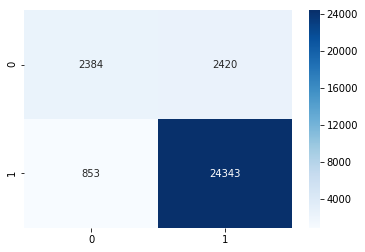

             precision    recall  f1-score   support

   Negative       0.74      0.50      0.59      4804
   Positive       0.91      0.97      0.94     25196

avg / total       0.88      0.89      0.88     30000



In [36]:
#Fitting the model

Model=fit_and_val_model(w2v_train,y_train,w2v_test,y_test,"Wod2vec")

No handles with labels found to put in legend.


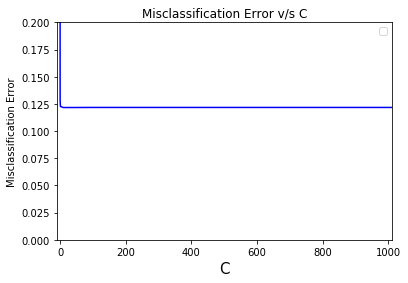

In [37]:
plot_error_vs_c_r(Model)

## Wieghted TF-IDF

In [38]:
#sentence vector creation
list_of_sent_train=[]
for sent in X_train.CleanedText:
    list_of_sent_train.append(sent.split())



    
list_of_sent_test=[]
for sent in X_test.CleanedText:
    list_of_sent_test.append(sent.split())
    
w2v_model=Word2Vec(list_of_sent_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

len(w2v_words)

10159

In [39]:
#TF-IDF Vectorizer initialization 

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
filtered_tf_idf = tf_idf_vect.fit(X_train.CleanedText)
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))
print("the type of count vectorizer ",type(filtered_tf_idf))


tf_idf_train=tf_idf_vect.transform(X_train.CleanedText)
tf_idf_test=tf_idf_vect.transform(X_test.CleanedText)

the type of count vectorizer  <class 'sklearn.feature_extraction.text.TfidfVectorizer'>


In [40]:
#creating weighted TF-IDF


def w_tf_idf(X,word_vector,model,tfidf_feat,filtered_tf_idf):
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
#    row=0;
    for sent in X: # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in word_vector:
                vec = model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
                tf_idf = dictionary[word]*sent.count(word)
                """tf_idf = filtered_tf_idf[row, tfidf_feat.index(word)]"""
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
#        row += 1
    print(len(tfidf_sent_vectors))
    print(len(tfidf_sent_vectors[0]))
    return tfidf_sent_vectors

In [41]:
tfidf_feat = tf_idf_vect.get_feature_names() 
tf_idf_sent_vectors_train=w_tf_idf(list_of_sent_train,w2v_words,w2v_model,tfidf_feat,tf_idf_train)
tf_idf_sent_vectors_test=w_tf_idf(list_of_sent_test,w2v_words,w2v_model,tfidf_feat,tf_idf_test)

70000
50
30000
50


In [42]:
#Feature scaling

scaler = Normalizer()
scaler.fit(w2v_train)
tfidf_wieghted_train=scaler.transform(tf_idf_sent_vectors_train)
tfidf_wieghted_test=scaler.transform(tf_idf_sent_vectors_test)

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

The model F-1 score is 86.16844131988583


F-1 Scores on test data on optimal parameters is  92.9712 %


[[ 1883  2921]
 [  772 24424]]


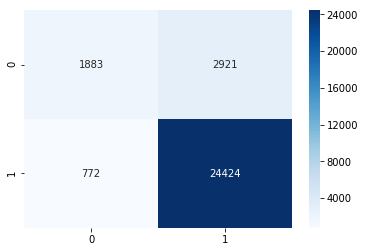

             precision    recall  f1-score   support

   Negative       0.71      0.39      0.50      4804
   Positive       0.89      0.97      0.93     25196

avg / total       0.86      0.88      0.86     30000



In [43]:
# Model fitting

Model=fit_and_val_model(tfidf_wieghted_train,y_train,tfidf_wieghted_test,y_test,"Wieghted TF-IDF")

No handles with labels found to put in legend.


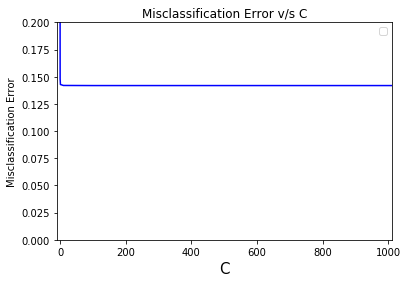

In [44]:
plot_error_vs_c_r(Model)

In [45]:
print(summary_table)

+-----------------+--------------+-----------+-------------------+
|      Method     |    Model     | Optimam C |     F-1 Score     |
+-----------------+--------------+-----------+-------------------+
|       BOW       | Logistic_Reg |    100    | 95.52663922433133 |
|      TF-IDF     | Logistic_Reg |   10000   | 95.62554851292052 |
|     Wod2vec     | Logistic_Reg |     10    | 93.70080255586136 |
| Wieghted TF-IDF | Logistic_Reg |   10000   | 92.97120344112217 |
+-----------------+--------------+-----------+-------------------+


### Conclusion:BOW and TF-IDF has performed better than word2vec and weighted TF-IDF model for Logistic Regression